# Setup data and requirements

In [1]:
from prepare_data import create_dataloaders
import torch

/home/emir/miniconda3/envs/mlptorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_dir = "../datasets/"

In [3]:
import torchvision

In [4]:
from torchvision import transforms

IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [5]:
train_data = torchvision.datasets.CIFAR10(root=dataset_dir,
                                         download=True,
                                         train=True,
                                         transform=manual_transforms)
test_data = torchvision.datasets.CIFAR10(root=dataset_dir,
                                        download=True,
                                        train=False,
                                        transform=manual_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
torch.cuda.device_count() 

1

In [8]:
device

'cuda'

In [9]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_data=train_data,
                                                                   test_data=test_data,
                                                                   data_folder_imported=True,
                                                                   batch_size=32,
                                                                   transform=manual_transforms)

In [10]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [12]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

In [13]:
image.shape, label

(torch.Size([3, 224, 224]), tensor(8))

(-0.5, 223.5, 223.5, -0.5)

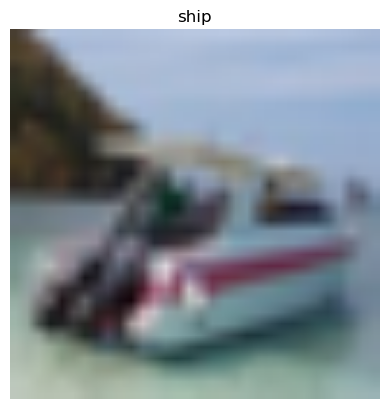

In [14]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

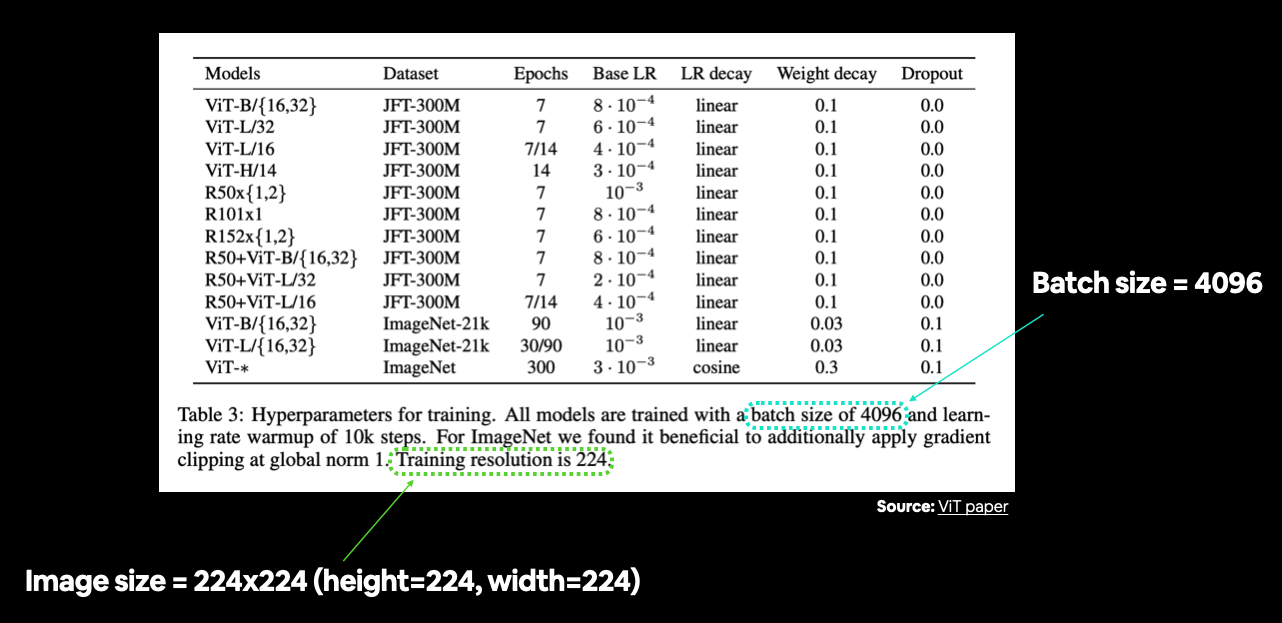

In [15]:
IMG_SIZE

224

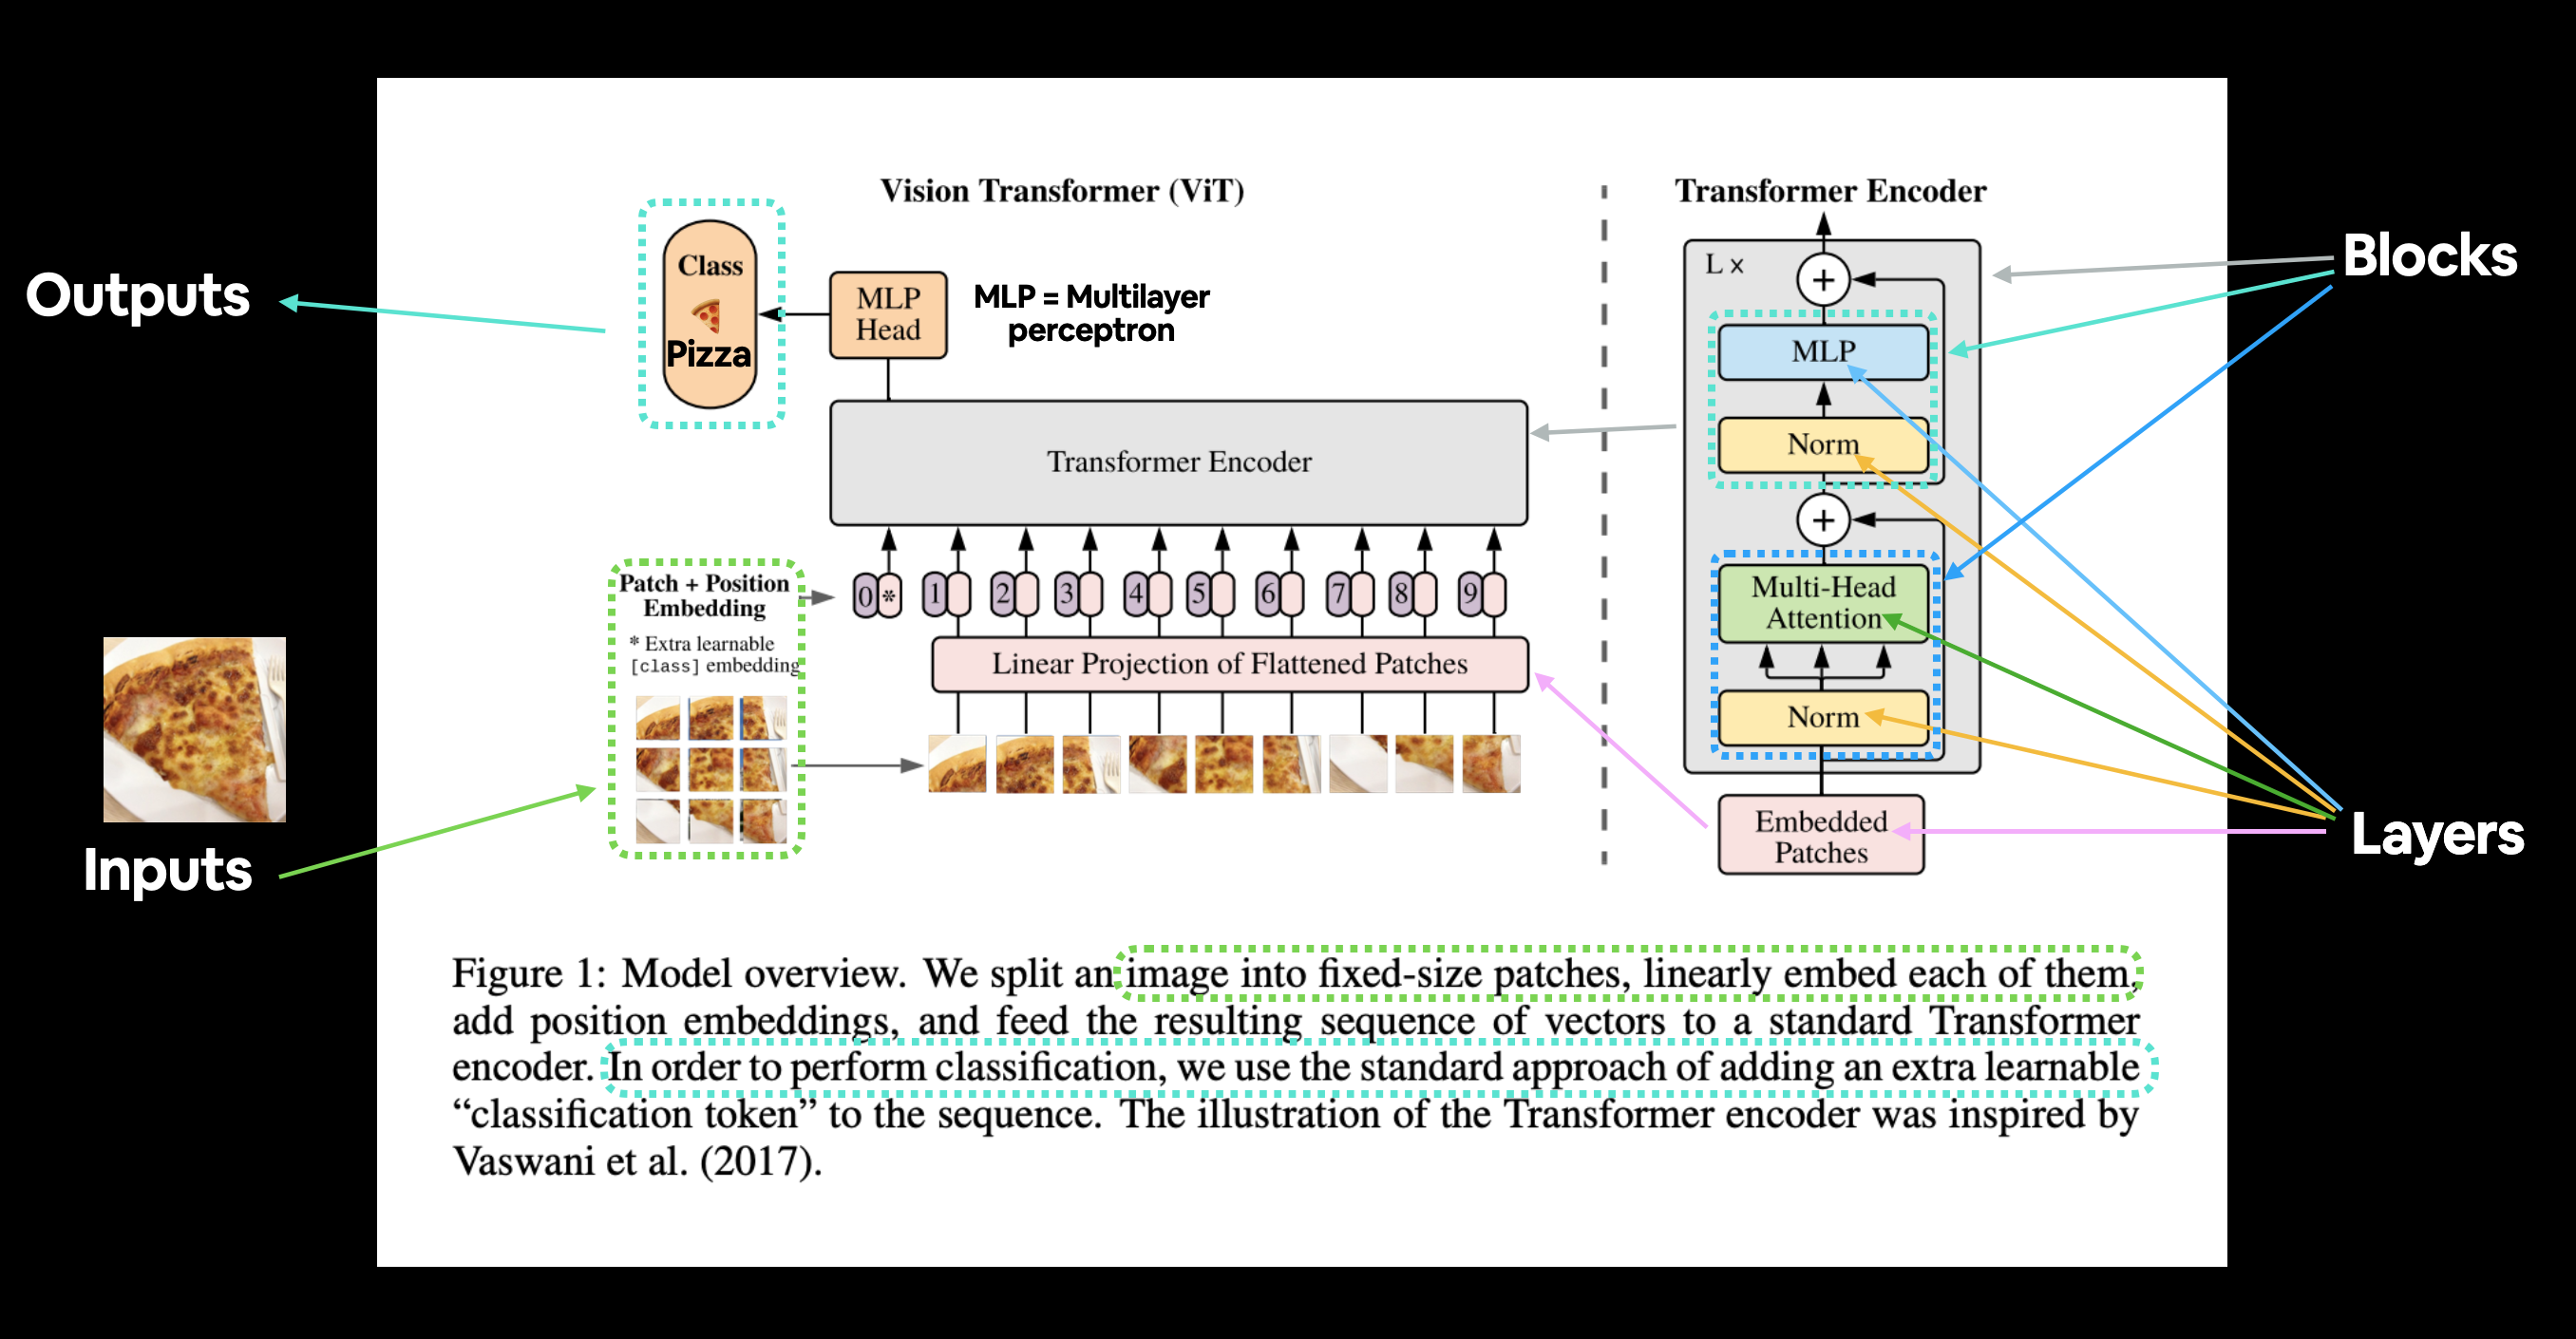

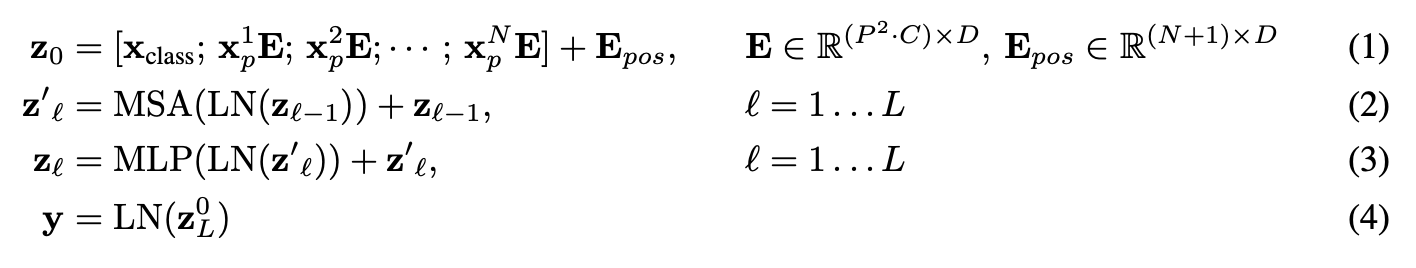

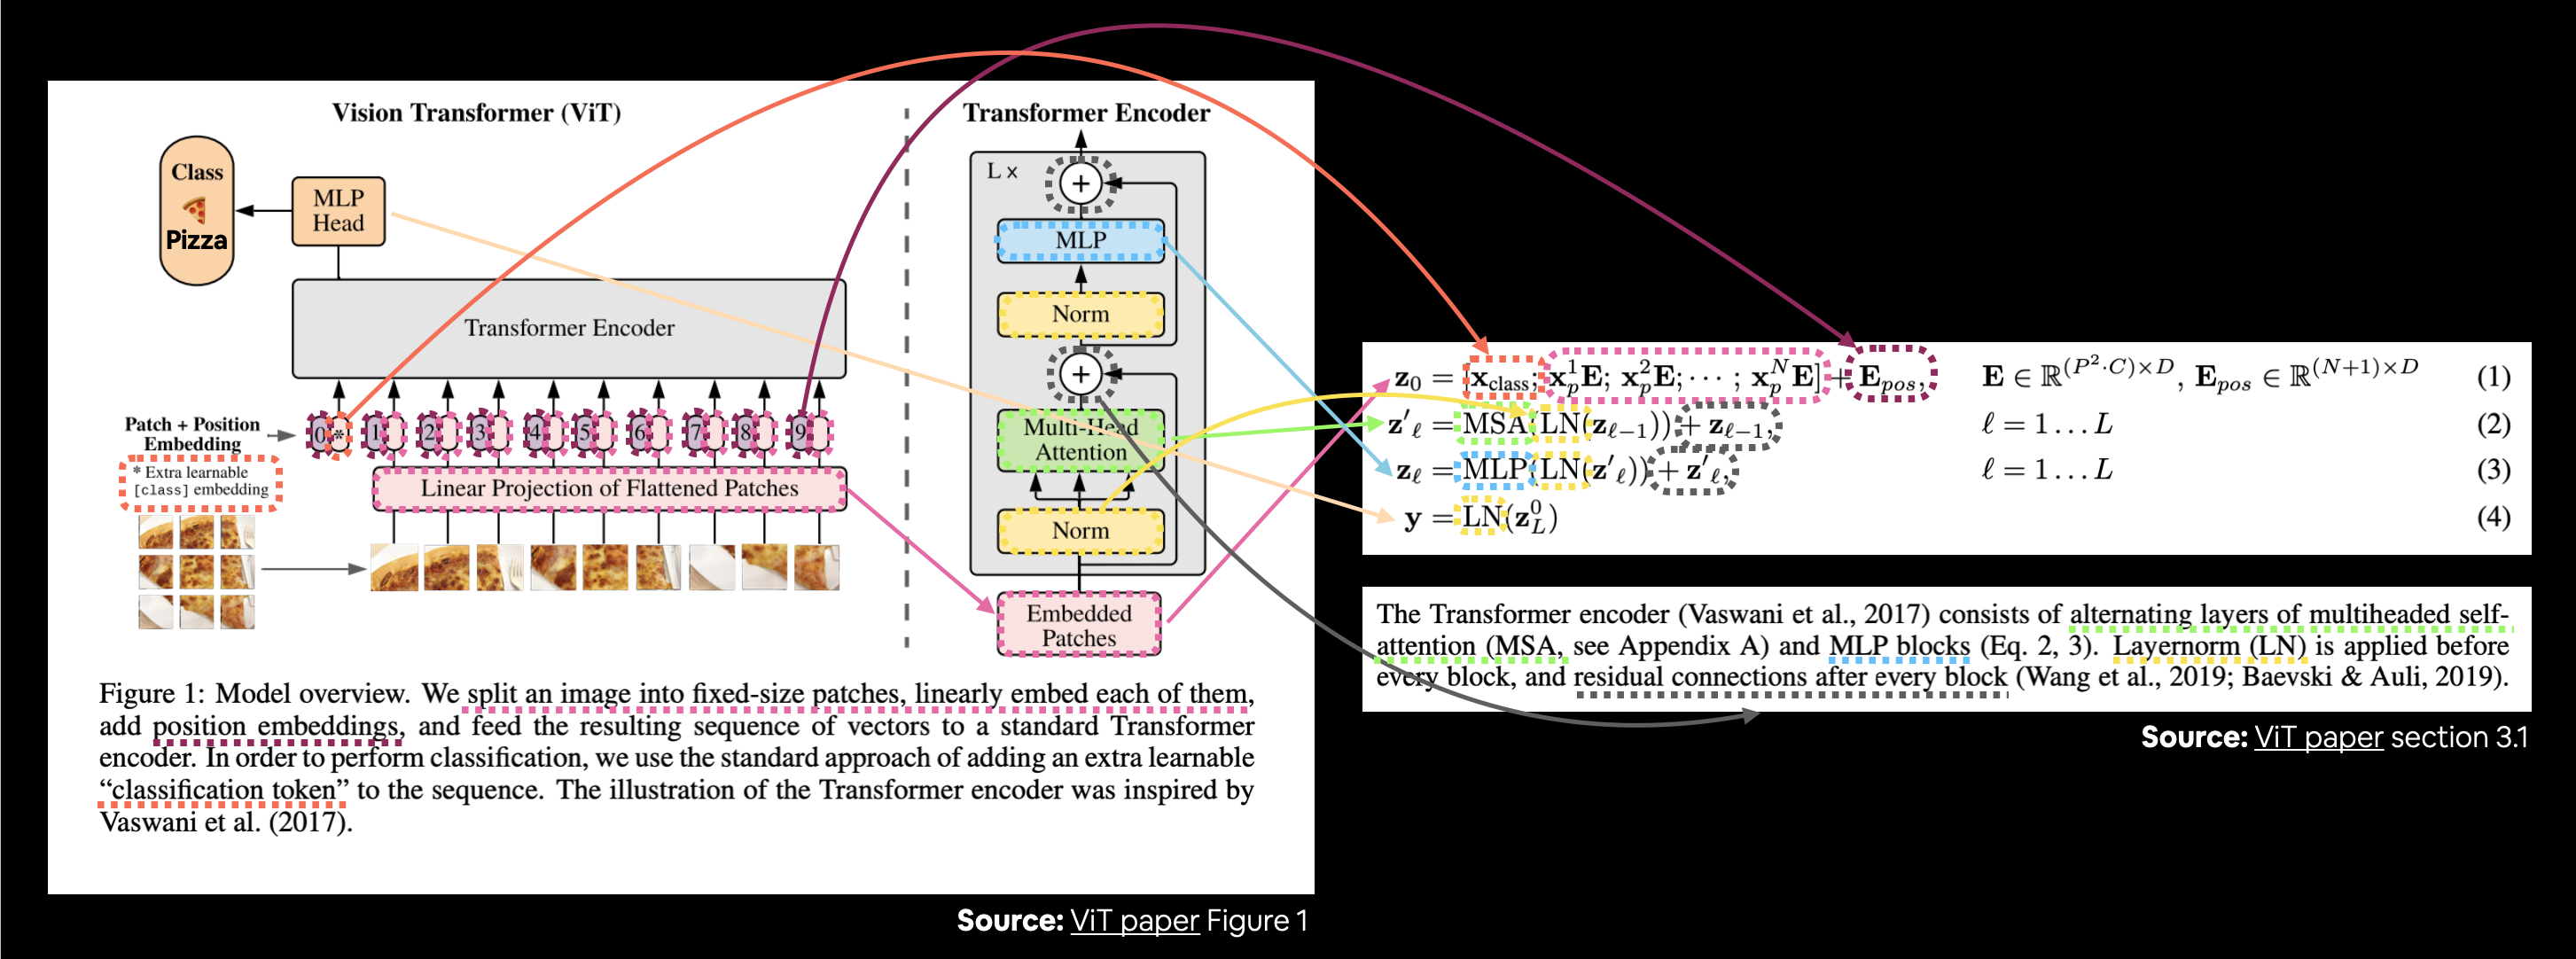

In [16]:
h, w = 224, 224
c = 3
patch_size = 16
number_patches = int((h * w) / patch_size**2)
number_patches

196

In [17]:
embed_input_shape = (h, w, c)
embed_out_shape = (number_patches, patch_size**2*c)
embed_input_shape, embed_out_shape

((224, 224, 3), (196, 768))

# first should permute the images in order to fit (h, w, c) form

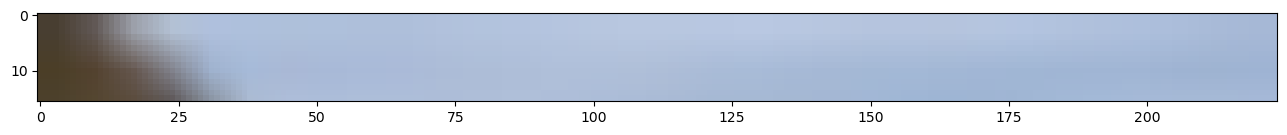

In [18]:
permuted_image = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(permuted_image[:patch_size,:,:]);

Every row there will be 14.0 with 16x16 resolution


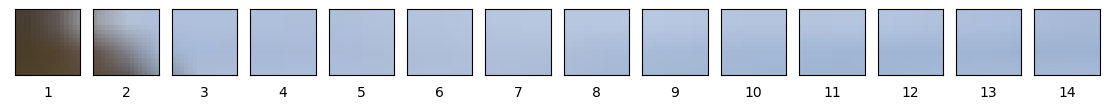

In [19]:
# so img size and patch_size should be compatible so that we can divice image to 16x16 patches
num_patches = IMG_SIZE / patch_size
print(f"Every row there will be {num_patches} with {patch_size}x{patch_size} resolution")

fig, axs = plt.subplots(nrows=1,
                       ncols=IMG_SIZE // patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)
for i, patch in enumerate(range(0, IMG_SIZE, patch_size)):
    axs[i].imshow(permuted_image[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Every row there will be 14.0 with 16x16 resolution


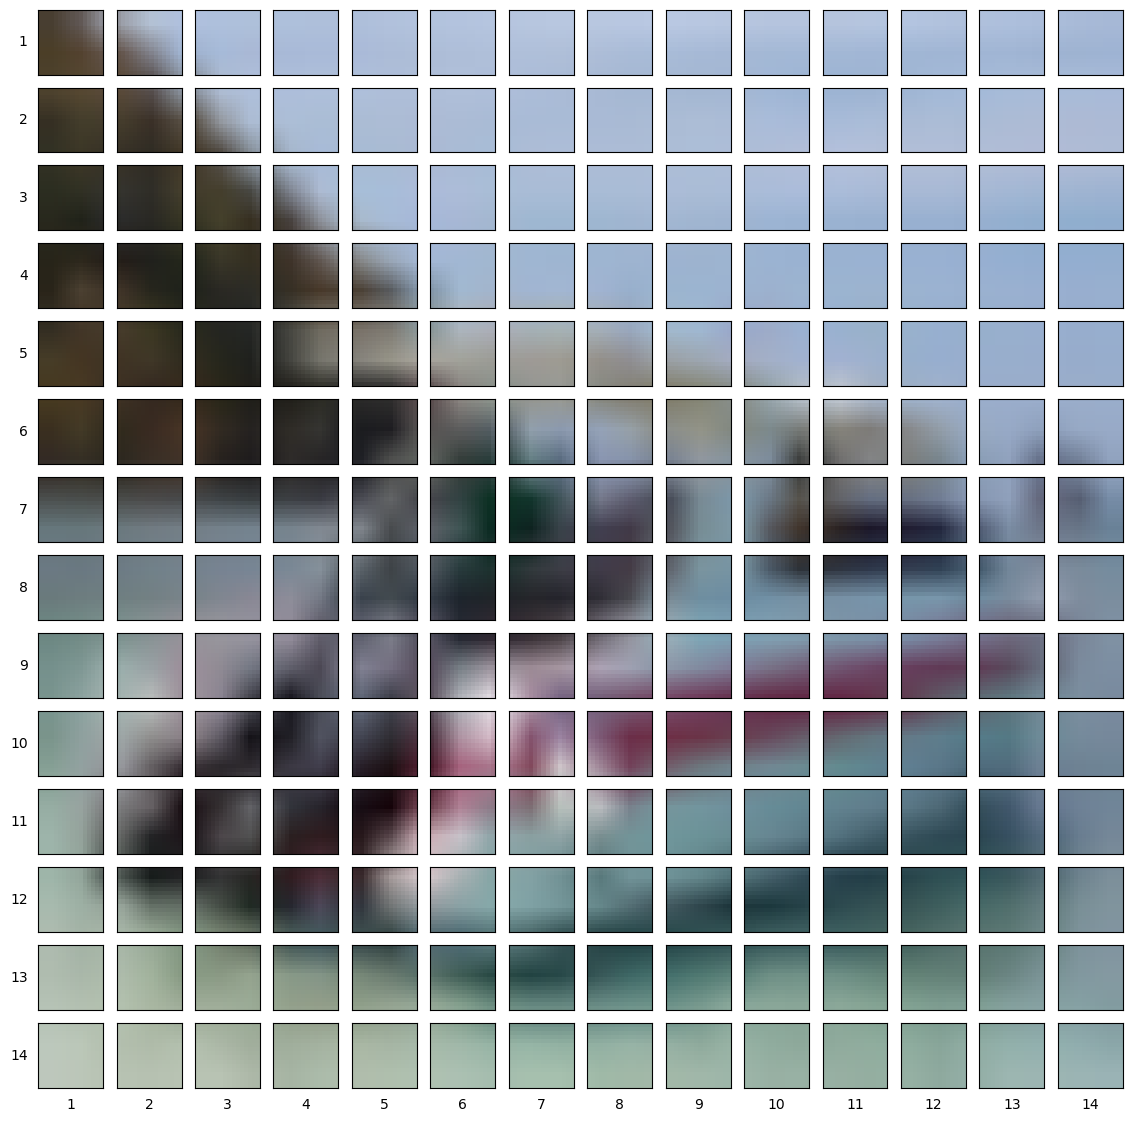

In [20]:
# so above we divided one row into equilavent patches now here comes to divide all image

num_patches = IMG_SIZE / patch_size
print(f"Every row there will be {num_patches} with {patch_size}x{patch_size} resolution")

fig, axs = plt.subplots(nrows=IMG_SIZE // patch_size,
                       ncols=IMG_SIZE // patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)
for i, patch_h in enumerate(range(0, IMG_SIZE, patch_size)):
    for j, patch_w in enumerate(range(0, IMG_SIZE, patch_size)):
        axs[i, j].imshow(permuted_image[patch_h:patch_h+patch_size,
                                        patch_w:patch_w+patch_size, 
                                        :])
        
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

In [21]:
from torch import nn

conv2d = nn.Conv2d(in_channels=3,
                  out_channels=768,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)

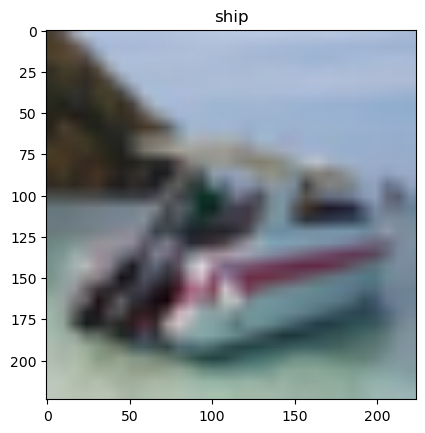

In [22]:
plt.imshow(permuted_image)
plt.title(class_names[label]);

In [23]:
out_conv_img = conv2d(image.unsqueeze(0))
print(out_conv_img.shape)

torch.Size([1, 768, 14, 14])


In [24]:
image.shape, permuted_image.shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

### what we get is [1, 768, 14, 14]  =>  [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [657, 683, 609, 660, 27]


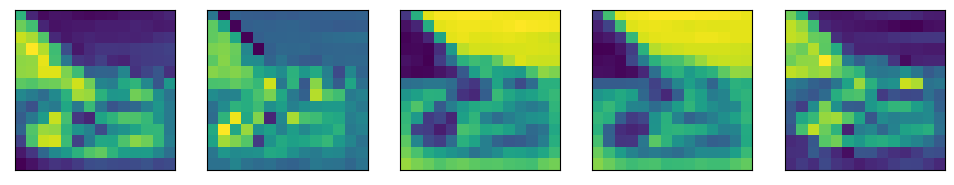

In [25]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = out_conv_img[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [26]:
single_feature = out_conv_img[:, 0, :, :]
single_feature, single_feature.requires_grad

(tensor([[[-0.1485, -0.3212, -0.3338, -0.3210, -0.3261, -0.3353, -0.3448,
           -0.3474, -0.3481, -0.3395, -0.3381, -0.3333, -0.3223, -0.3080],
          [-0.1377, -0.1707, -0.3053, -0.3348, -0.3264, -0.3252, -0.3187,
           -0.3105, -0.3082, -0.3002, -0.2966, -0.3043, -0.3122, -0.3134],
          [-0.0851, -0.1053, -0.1624, -0.2936, -0.3342, -0.3219, -0.3200,
           -0.3235, -0.3247, -0.3199, -0.3284, -0.3230, -0.3176, -0.3134],
          [-0.0631, -0.0535, -0.0882, -0.1111, -0.2459, -0.3243, -0.3121,
           -0.3028, -0.2998, -0.2975, -0.2932, -0.2882, -0.2826, -0.2789],
          [-0.1024, -0.1057, -0.0629, -0.1635, -0.2846, -0.3400, -0.3360,
           -0.3240, -0.3453, -0.3006, -0.2899, -0.2826, -0.2856, -0.2825],
          [-0.1044, -0.0800, -0.0563, -0.0525, -0.0542, -0.2064, -0.2809,
           -0.2741, -0.2409, -0.3003, -0.3447, -0.2813, -0.3140, -0.3108],
          [-0.0850, -0.0780, -0.0548, -0.0531, -0.1093, -0.1271, -0.1045,
           -0.2325, -0.1800, -0.

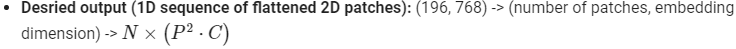

In [27]:
flatten_layer = nn.Flatten(start_dim=2,
                          end_dim=3)

torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])


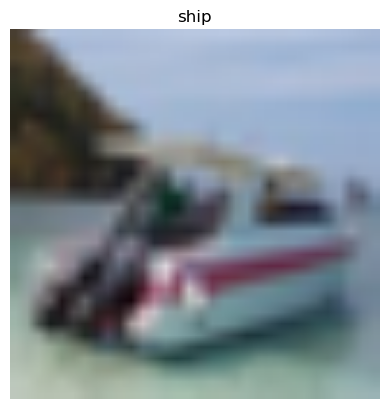

In [28]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
out_conv_img = conv2d(image.unsqueeze(0))
print(out_conv_img.shape)
out_conv_img = flatten_layer(out_conv_img)
print(out_conv_img.shape)

In [29]:
image_flattened_reshaped = out_conv_img.permute(0, 2, 1)
print(image_flattened_reshaped.squeeze(0).shape)

torch.Size([196, 768])


In [30]:
image_flattened_reshaped[:, :, 0].shape, image_flattened_reshaped.shape

(torch.Size([1, 196]), torch.Size([1, 196, 768]))

(-0.5, 195.5, 0.5, -0.5)

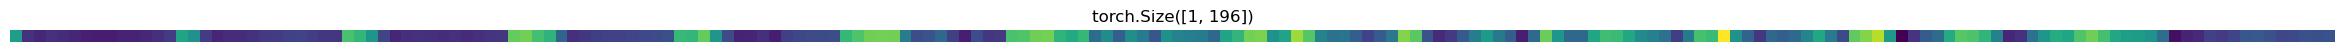

In [31]:
single_feature_map = image_flattened_reshaped[:, :, 0]
plt.figure(figsize=(30, 30))
plt.imshow(single_feature_map.detach().numpy())
plt.title(single_feature_map.shape)
plt.axis(False)

In [32]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                 end_dim=3)
    
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"input image shape is not compatible"
        
        x_patched = self.patcher(x)
        x_flattend = self.flatten(x_patched)
        return x_flattend.permute(0, 2, 1)
        

In [33]:
patcher = PatchEmbedding(in_channels=3,
                        patch_size=16,
                        embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded = patcher(image.unsqueeze(0))
print(f"Output patch embed shape: {patch_embedded.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embed shape: torch.Size([1, 196, 768])


In [34]:
# LEFT IN 4.5

In [35]:
batch_size = patch_embedded.shape[0]
batch_size

1

In [36]:
embed_dim = patch_embedded.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embed_dim),
                          requires_grad=True)

print(class_token[:, :, :10])
print(class_token.shape)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 1, 768])


In [37]:
patch_embed_class_token = torch.cat((class_token, patch_embedded),
                                   dim=1)
patch_embed_class_token.shape

torch.Size([1, 197, 768])

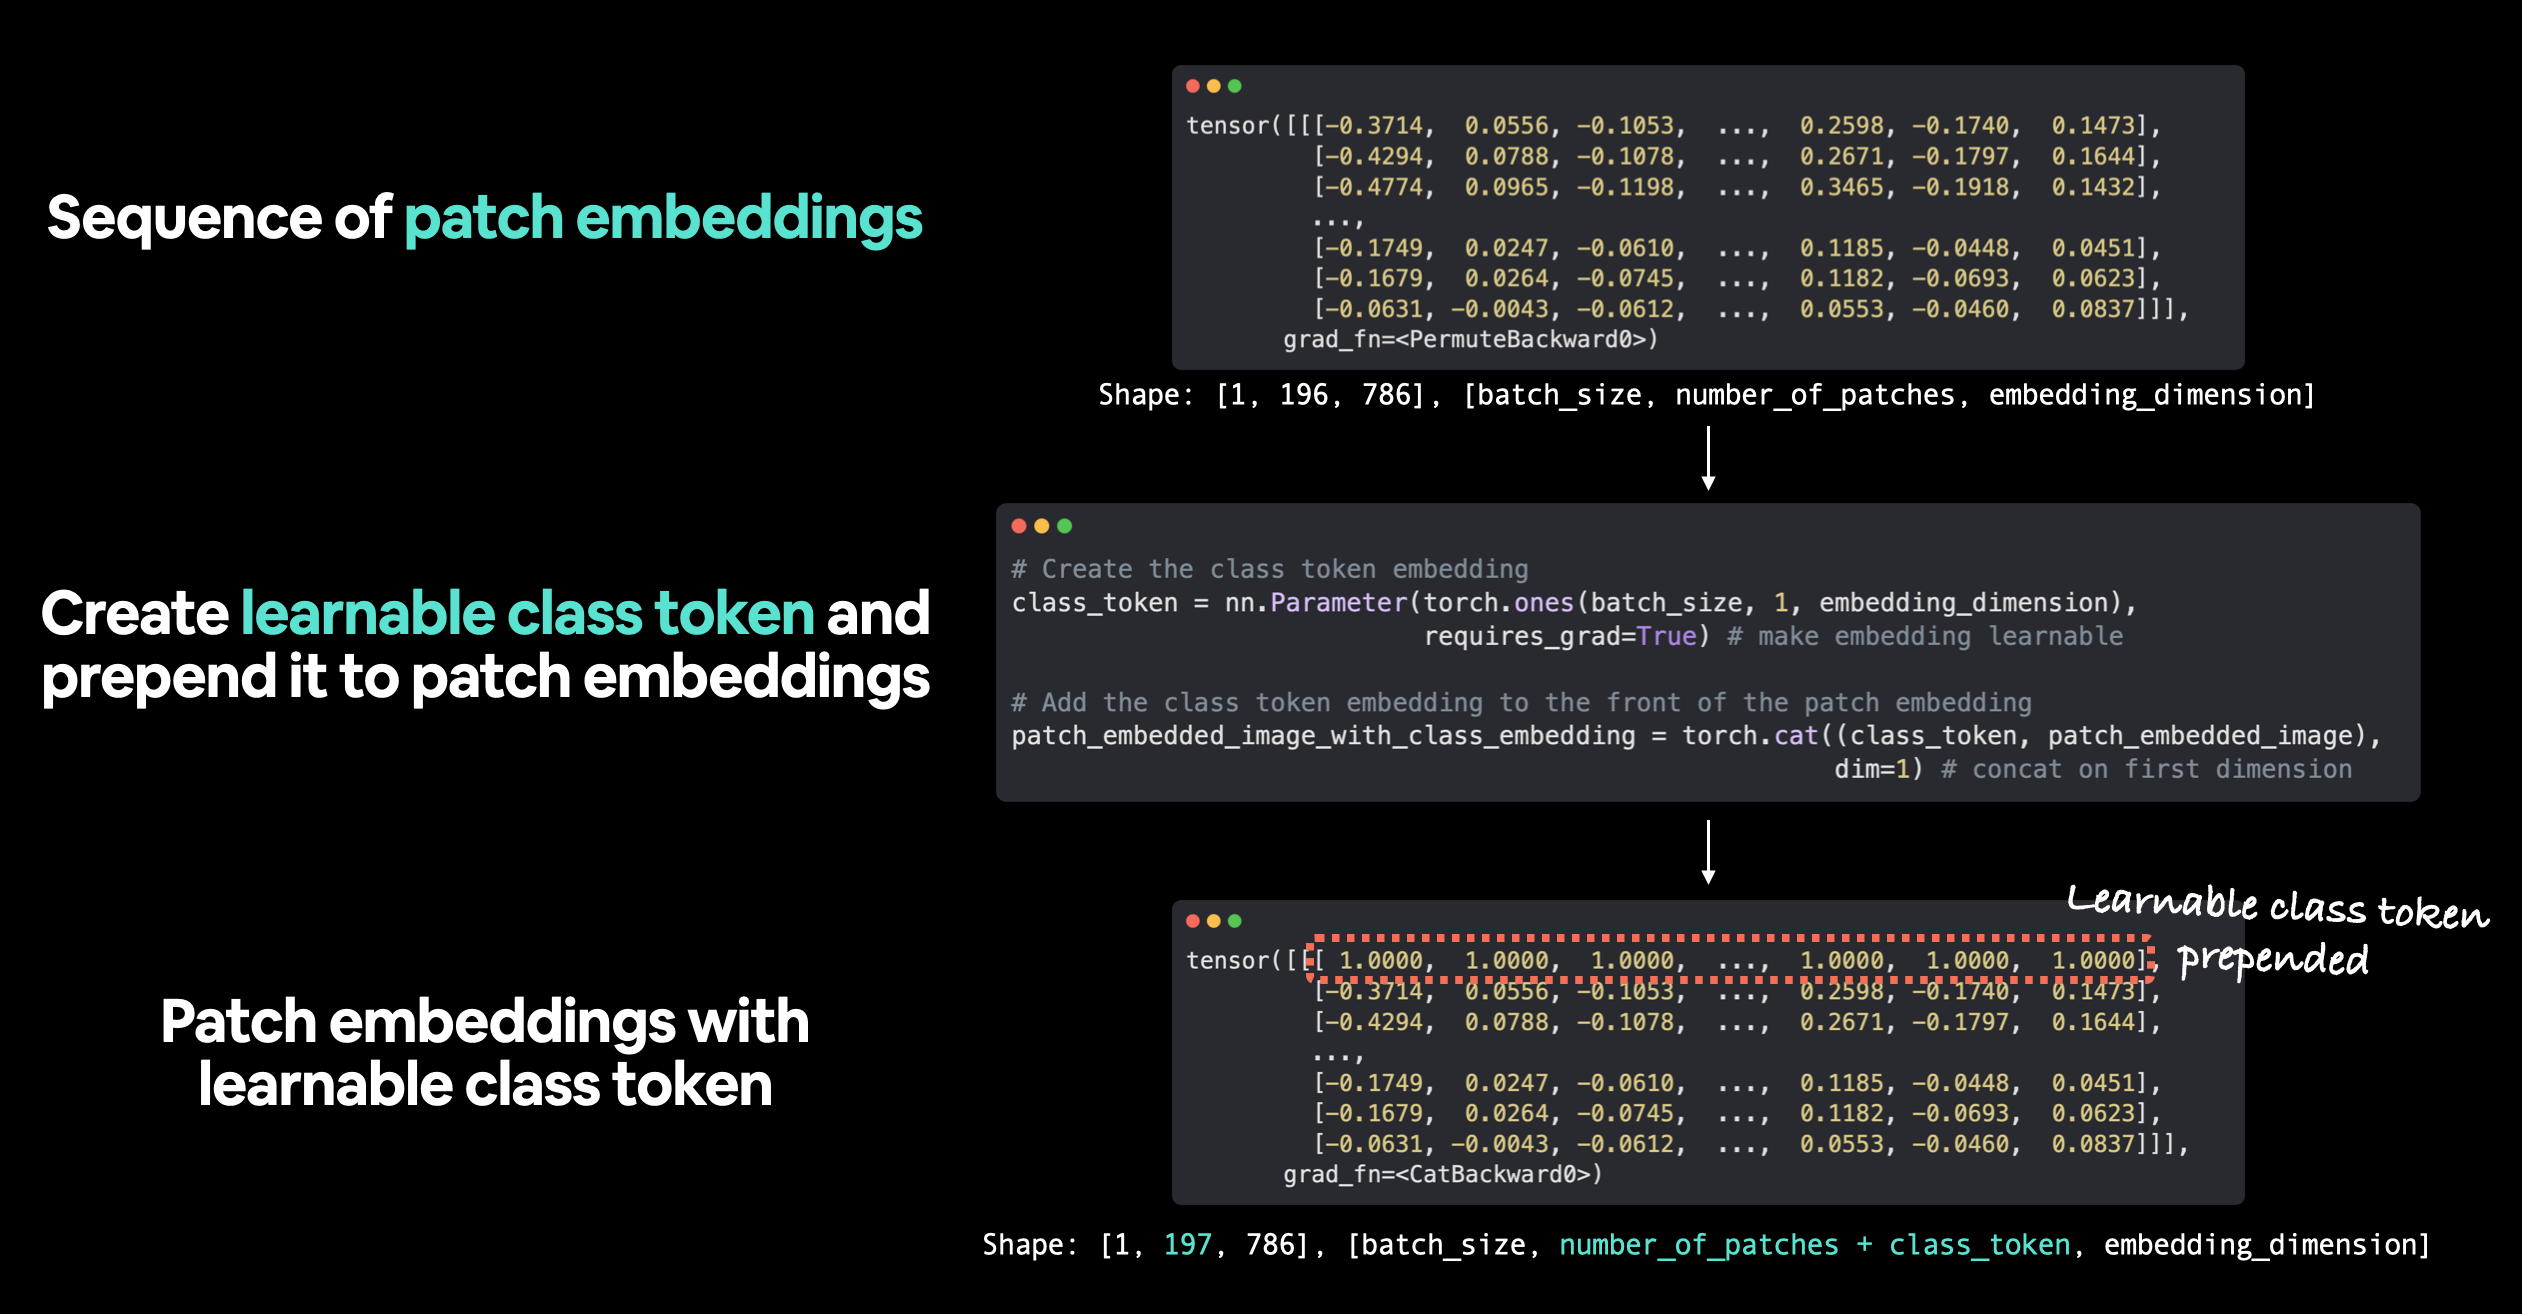

In [38]:
number_patches

196

In [39]:
embed_dim

768

In [40]:
embed_dim = patch_embed_class_token.shape[2]

In [41]:
embed_dim

768

In [42]:
position_embedding = nn.Parameter(torch.ones(1,
                                            number_patches+1,
                                            embed_dim),
                                 requires_grad=True)

print(position_embedding.shape)

torch.Size([1, 197, 768])


In [43]:
patch_pos_embed = patch_embed_class_token + position_embedding
print(patch_pos_embed.shape)

torch.Size([1, 197, 768])


In [44]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

patch_size = 16
print(image.shape, "image shape")
x = image.unsqueeze(0)
print(x.shape, "--0")
patch_layer = PatchEmbedding(in_channels=3,
                            patch_size=patch_size,
                            embedding_dim=768)

patch_embedding = patch_layer(x)
print(patch_embedding.shape, "--1")
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
print(batch_size, embedding_dimension, "--2") # batch_size = 1, embedding dimension = 768
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True)
print(class_token.shape, "--3")
patch_embed_class = torch.cat((class_token, patch_embedding), dim=1)
print(patch_embed_class.shape, "--4")
position_embedding = nn.Parameter(torch.ones(1,
                                            number_patches+1, embedding_dimension),
                                 requires_grad=True)
print(position_embedding.shape, "--5")
patch_class_position_embedings = patch_embed_class + position_embedding
print(patch_class_position_embedings.shape, "--6")

torch.Size([3, 224, 224]) image shape
torch.Size([1, 3, 224, 224]) --0
torch.Size([1, 196, 768]) --1
1 768 --2
torch.Size([1, 1, 768]) --3
torch.Size([1, 197, 768]) --4
torch.Size([1, 197, 768]) --5
torch.Size([1, 197, 768]) --6


In [45]:
position_embedding.shape, patch_class_position_embedings.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png)

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png)

In [46]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, embedding_dim:int=768,
                num_heads:int=12,
                dropout:int=0) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
    
    def forward(self, x):
        x = self.layer_norm(x)
        attention_out, _ = self.multihead_attention(query=x, key=x, value=x, need_weights=False)
        return attention_out

In [47]:
msa_block = MultiHeadAttentionBlock(embedding_dim=768, 
                                    num_heads=12)

patched_image_msa_process = msa_block(patch_class_position_embedings)

print(patched_image_msa_process.shape, patch_class_position_embedings.shape)

torch.Size([1, 197, 768]) torch.Size([1, 197, 768])


In [48]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1) -> None:
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [49]:
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

patched_image_mlp_process = mlp_block(patched_image_msa_process)
print(patched_image_msa_process.shape, patched_image_mlp_process.shape)

torch.Size([1, 197, 768]) torch.Size([1, 197, 768])


In [50]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:int=0.1,
                 attn_dropout:int=0) -> None:
        super().__init__()
        
        self.msa_block = MultiHeadAttentionBlock(embedding_dim=embed_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embed_dim,
                                    mlp_size=mlp_size,
                                    dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [51]:
from torchinfo import summary

In [52]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttentionBlock (msa_block)                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [53]:
class ViT(nn.Module):
    def __init__(self,
                img_size:int=224,
                in_channels:int=3,
                patch_size:int=16,
                num_transformer_layers:int=12,
                embedding_dim:int=768,
                mlp_size:int=3072,
                num_heads:int=12,
                attn_dropout:int=0,
                mlp_dropout:int=0.1,
                embedding_dropout:int=0.1,
                num_classes:int=1000) -> None:
        super().__init__()

        assert img_size % patch_size == 0, f"Not compatible image size with 16"

        self.num_patches = (img_size**2) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes))
    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1) # What is this line doing ??? search it

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x 

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

In [54]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)


print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [55]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

random_image_tensor = torch.randn(1, 3, 224, 224)

vit_model = ViT(num_classes=len(class_names))

vit_model(random_image_tensor)

tensor([[ 0.9189, -0.7690, -0.1831,  0.1487, -0.2740,  0.6596, -0.5337, -0.5150,
          0.0473, -0.2510]], grad_fn=<AddmmBackward0>)

In [56]:
summary(model=vit_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 10]             152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           

One slight but important part of the model is the positional encoding of the different words. Since we have no recurrent networks that can remember how sequences are fed into a model, we need to somehow give every word/part in our sequence a relative position since a sequence depends on the order of its elements. These positions are added to the embedded representation (n-dimensional vector) of each word.

![](https://miro.medium.com/max/720/1*ETe4WrKJ1lS1MKDgBPIM0g.png)

![](https://ryanong.co.uk/wp-content/uploads/2020/01/Attention-formula.png)

Q is a matrix that contains the query (vector representation of one word in the sequence), K are all the keys (vector representations of all the words in the sequence) and V are the values, which are again the vector representations of all the words in the sequence. For the encoder and decoder, multi-head attention modules, V consists of the same word sequence than Q. However, for the attention module that is taking into account the encoder and the decoder sequences, V is different from the sequence represented by Q.

To simplify this a little bit, we could say that the values in V are multiplied and summed with some attention-weights a, where our weights are defined by:

![](https://miro.medium.com/max/640/1*77nNekispauiE34dz6hEKw.png)

https://www.youtube.com/watch?v=TQQlZhbC5ps

Batch Normalization and Layer Normalization

Batch Normalization(BN)
BN layer transforms each input in the current mini-batch by subtracting the input mean in the current mini-batch and dividing it by the standard deviation.

But each layer doesn’t need to expect inputs with zero mean and unit variance, but instead, probably the model might perform better with some other mean and variance. Hence the BN layer also introduces two learnable parameters γ and β.

https://www.youtube.com/watch?v=DtEq44FTPM4

Layer Normalization(LN)
Inspired by the results of Batch Normalization, Geoffrey Hinton et al. proposed Layer Normalization which normalizes the activations along the feature direction instead of mini-batch direction. This overcomes the cons of BN by removing the dependency on batches and makes it easier to apply for RNNs as well.

In essence, Layer Normalization normalizes each feature of the activations to zero mean and unit variance.

https://arxiv.org/pdf/1607.06450.pdf

![](https://miro.medium.com/max/720/1*rwQgG3lrQFfjWac8k14SbA.png)

Normalization of inputs

https://stats.stackexchange.com/questions/322822/how-normalizing-helps-to-increase-the-speed-of-the-learning

https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

https://github.com/Jaewan-Yun/optimizer-visualization

In [57]:
from train import train
import numpy as np

WHAT IS WEIGHT DECAY HYPERPARAMETER???

In [58]:
summary(model=vit_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 10]             152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           

In [59]:
vit_model.parameters()

<generator object Module.parameters at 0x7fc7e01b38b0>

Simply put Betas are used as for smoothing the path to the convergence also providing some momentum to cross a local minima or saddle point. Now how does it affects can be thought of as Beta default value 0.9 just averages the gradient or (square of the gradient) of previous 10 batches which is calculated by 1/(1-0.9) which means it represent how we are coming from last 10 batches down when minimizing the loss. So instead of tuning that you can always tune the batch size it will have almost same impact!

In [60]:
from train import train


In [ ]:
optimizer = nn.optim.Adam()

results = train(model=vit_model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, )